In [2]:
import torch

import numpy as np

from skimage.transform import resize

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt


import skimage as sk
import skimage.io as skio

from sklearn.model_selection import train_test_split

In [3]:
import glob

In [6]:
from tqdm import tqdm

In [143]:
def display_grid_of_images(array_of_images, array_of_names, w = 6, h = 5, normalize_rgb = False, hide_axes = True):
    num_rows = len(array_of_images)
    num_cols = len(array_of_images[0])
    
    assert len(array_of_names) == num_rows, "same num of rows for names and images"
    
    assert all([len(row) == num_cols for row in array_of_images]), "all rows need to be same length"
    assert all([len(row) == num_cols for row in array_of_names]), "all rows need to be same length for strings too"
    
    fig = plt.figure(figsize=(w * num_cols, h * num_rows))
    subplots = fig.subplots(num_rows, num_cols, squeeze = False)
    
    for row in range(num_rows):
        for col in range(num_cols):
            
            ax = subplots[row, col]
            ax.set_title(array_of_names[row][col])
            pixels = array_of_images[row][col]
            if hide_axes:
                ax.set_axis_off()
            
            if len(pixels.shape) == 2:
                # grayscale (scalars)
                ax.imshow(pixels,cmap='Greys_r')
            if len(pixels.shape) == 3:
                # rgb
                if normalize_rgb:
                    # gotta normalize the rgb ones too!
                    pixels = pixels - np.min(pixels)
                    pixels = pixels / np.max(pixels)
                ax.imshow(pixels)
def display_dictionary_of_images(dic, prefix = '', horiz = False, w = 6, h = 5, normalize_rgb = False, hide_axes = True):
    %matplotlib inline
    
    if horiz:
    
        fig = plt.figure(figsize=(w * len(dic), h))
        try:
            subplots = list(fig.subplots(1, len(dic)))
        except:
            subplots = [fig.subplots(1, len(dic))]
    else:
        fig = plt.figure(figsize=(w, h * len(dic)))
        try:
            subplots = list(fig.subplots(len(dic), 1))
        except:
            subplots = [fig.subplots(len(dic), 1)]
    
    keylist = list(dic.keys())
    
    for i in range(len(dic)):
        key = keylist[i]      
        pixels = dic[key]

        #Display the image
        ax = subplots[i]
        ax.set_title(prefix + ' ' + key)
        if hide_axes:
                ax.set_axis_off()
        if len(pixels.shape) == 2:
            # grayscale (scalars)
            ax.imshow(pixels,cmap='Greys_r')
        if len(pixels.shape) == 3:
            # rgb
            # gotta normalize the rgb ones too!
            if normalize_rgb:
                pixels = pixels - np.min(pixels)
                pixels = pixels / np.max(pixels)
            ax.imshow(pixels)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))


Using cuda device


In [12]:
def get_data():
    anno_names = glob.glob("data/imm_face_db/*.asf")
    face_names = [s[:-3]+'jpg' for s in anno_names]
    
    noses = []

    for anno_name in anno_names:
        file = open(anno_name)
        points = file.readlines()[16:74]
        landmark = []

        for point in points:
            x,y = point.split('\t')[2:4]
            landmark.append([float(x), float(y)])

        # the nose keypoint
        noses.append(np.array(landmark).astype('float32')[-6])     
    noses = np.array(noses)

    faces = []

    for face_name in face_names:

        img = skio.imread(face_name)
        img = (img.astype(np.float32) / 255 - 0.5)
        img = resize(img, (60,80), anti_aliasing=True)
        img = np.mean(img, axis = 2)
        faces.append(img)
        
    faces = np.array(faces)
    
    return faces, noses


In [13]:
X_all, y_all = get_data()

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=48, random_state=None, shuffle = False)

In [41]:
X_val.shape

(48, 60, 80)

In [42]:
X_train.shape

(192, 60, 80)

In [15]:
class NosesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,X, y, transform=None):
        
        assert len(X) == len(y)
        
        self.transform = transform
                    
        self.faces = torch.Tensor(X).unsqueeze(1)
        
        
        self.noses = torch.Tensor(y)
        
    def __len__(self):
        return len(self.noses)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()

        
        sample = {'image': self.faces[idx], 'nose': self.noses[idx]}

        if self.transform:
            sample = self.transform(sample)

        return sample


In [16]:
train_dataset = NosesDataset(X_train, y_train)

In [17]:
val_dataset = NosesDataset(X_val, y_val)

In [18]:
train_dataset[0]['image'].shape

torch.Size([1, 60, 80])

In [20]:
def train(dataloader, model, loss_fn, optimizer):
    
    size = len(dataloader.dataset)
    print(f"training on {size} samples")
    model.train()
    
    total_loss = 0
    
    for bidx, batch in tqdm(enumerate(dataloader)):
        
        # send data to gpu
        x, y = batch['image'], batch['nose']
        x, y = x.to(device), y.to(device)
        
        # do the forward/backward pass
        model.zero_grad()
        output = model(x)
        loss = loss_fn(output,y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        
    mean_loss = total_loss/(bidx + 1)
        
    return mean_loss

def validate(dataloader, model, loss_fn):
    
    size = len(dataloader.dataset)
    print(f"validating on {size} samples")
    model.eval()
    
    total_loss = 0
    
    for bidx, batch in enumerate(dataloader):
        
        # send data to gpu
        x, y = batch['image'], batch['nose']
        x, y = x.to(device), y.to(device)
        
        # do the forward pass
        output = model(x)
        loss = loss_fn(output,y)      
        total_loss += loss
        
    mean_loss = total_loss/(bidx + 1)
        
    return mean_loss

def predict(dataloader, model):
    
    outputs = []
    model.eval()
    for bidx, batch in enumerate(dataloader):
        
        # send data to gpu
        x, y = batch['image'], batch['nose']
        x, y = x.to(device), y.to(device)
        
        # do the forward pass
        output = model(x)
        
        # send data back to cpu and convert to np
        output = output.cpu()
        outputs.append(output.detach().numpy())
    
    all_outputs = np.stack(outputs, axis=0)
    return all_outputs
        
        

In [21]:
BATCH_SIZE = 1
NUM_EPOCHS = 25

In [49]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [53]:
class NoseNet(nn.Module):

    def __init__(self):
        super(NoseNet, self).__init__()
        # 1 input image channel, 12 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.conv2 = nn.Conv2d(12, 12, 5)
        self.conv3 = nn.Conv2d(12, 12, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(288, 100)  # 5*5 from image dimension
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [54]:
model = NoseNet().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

NoseNet(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


In [55]:
train_loss_history = []
val_loss_history = []

In [56]:
val_loss_running_avg = [999, 999,999,999,999]
for epoch in range(NUM_EPOCHS):
    train_loss = train(train_loader, model, loss_fn, optimizer)
    val_loss = validate(val_loader, model, loss_fn)
    
    train_loss_history.append(train_loss.item())
    val_loss_history.append(val_loss.item())
    
#     if epoch > 10 and val_loss >= (sum(val_loss_running_avg)/len(val_loss_running_avg)):
#         break
    val_loss_running_avg.pop(0)
    val_loss_running_avg.append(val_loss)
    print(f"epoch {epoch}, train_loss {train_loss}, val_loss {val_loss}")

training on 192 samples


192it [00:00, 545.90it/s]


validating on 48 samples
epoch 0, train_loss 0.015417641960084438, val_loss 0.004851881414651871
training on 192 samples


192it [00:00, 555.43it/s]


validating on 48 samples
epoch 1, train_loss 0.005957258865237236, val_loss 0.004729804582893848
training on 192 samples


192it [00:00, 569.28it/s]


validating on 48 samples
epoch 2, train_loss 0.005206492729485035, val_loss 0.004844702780246735
training on 192 samples


192it [00:00, 550.54it/s]


validating on 48 samples
epoch 3, train_loss 0.004012769553810358, val_loss 0.002814041916280985
training on 192 samples


192it [00:00, 571.64it/s]


validating on 48 samples
epoch 4, train_loss 0.0032591349445283413, val_loss 0.002399504417553544
training on 192 samples


192it [00:00, 572.99it/s]


validating on 48 samples
epoch 5, train_loss 0.0027188886888325214, val_loss 0.001703924499452114
training on 192 samples


192it [00:00, 550.08it/s]


validating on 48 samples
epoch 6, train_loss 0.002160243922844529, val_loss 0.0014288014499470592
training on 192 samples


192it [00:00, 529.46it/s]


validating on 48 samples
epoch 7, train_loss 0.0017707652878016233, val_loss 0.0011248510563746095
training on 192 samples


192it [00:00, 558.83it/s]


validating on 48 samples
epoch 8, train_loss 0.0014906906289979815, val_loss 0.001020805793814361
training on 192 samples


192it [00:00, 571.61it/s]


validating on 48 samples
epoch 9, train_loss 0.001302224351093173, val_loss 0.0009539694292470813
training on 192 samples


192it [00:00, 567.23it/s]


validating on 48 samples
epoch 10, train_loss 0.001153905875980854, val_loss 0.0008678021840751171
training on 192 samples


192it [00:00, 571.53it/s]


validating on 48 samples
epoch 11, train_loss 0.0010925583774223924, val_loss 0.0007966785924509168
training on 192 samples


192it [00:00, 560.91it/s]


validating on 48 samples
epoch 12, train_loss 0.0010305249597877264, val_loss 0.0007054414018057287
training on 192 samples


192it [00:00, 541.92it/s]


validating on 48 samples
epoch 13, train_loss 0.0010969245340675116, val_loss 0.0009818692924454808
training on 192 samples


192it [00:00, 544.92it/s]


validating on 48 samples
epoch 14, train_loss 0.001257585478015244, val_loss 0.0009969043312594295
training on 192 samples


192it [00:00, 544.88it/s]


validating on 48 samples
epoch 15, train_loss 0.0012068127980455756, val_loss 0.0007387155201286077
training on 192 samples


192it [00:00, 557.90it/s]


validating on 48 samples
epoch 16, train_loss 0.0008570297504775226, val_loss 0.0006243784446269274
training on 192 samples


192it [00:00, 574.00it/s]


validating on 48 samples
epoch 17, train_loss 0.0006880327127873898, val_loss 0.0004958715289831161
training on 192 samples


192it [00:00, 570.02it/s]


validating on 48 samples
epoch 18, train_loss 0.0005507461028173566, val_loss 0.0004684265877585858
training on 192 samples


192it [00:00, 568.57it/s]


validating on 48 samples
epoch 19, train_loss 0.000493984785862267, val_loss 0.00044689775677397847
training on 192 samples


192it [00:00, 555.07it/s]


validating on 48 samples
epoch 20, train_loss 0.0004494760069064796, val_loss 0.00046093063428997993
training on 192 samples


192it [00:00, 545.14it/s]


validating on 48 samples
epoch 21, train_loss 0.00040815165266394615, val_loss 0.00046088267117738724
training on 192 samples


192it [00:00, 539.95it/s]


validating on 48 samples
epoch 22, train_loss 0.00039350957376882434, val_loss 0.0004362277686595917
training on 192 samples


192it [00:00, 555.24it/s]


validating on 48 samples
epoch 23, train_loss 0.0003871752414852381, val_loss 0.00042898947140201926
training on 192 samples


192it [00:00, 571.36it/s]

validating on 48 samples
epoch 24, train_loss 0.00037201313534751534, val_loss 0.00042594026308506727


0.000425 for 1e-3, default

0.001149 for 1e-3, 6-6-12 conv

0.000844 for 1e-4, default layer sizes

In [57]:
train_loss_history

[0.015417641960084438,
 0.005957258865237236,
 0.005206492729485035,
 0.004012769553810358,
 0.0032591349445283413,
 0.0027188886888325214,
 0.002160243922844529,
 0.0017707652878016233,
 0.0014906906289979815,
 0.001302224351093173,
 0.001153905875980854,
 0.0010925583774223924,
 0.0010305249597877264,
 0.0010969245340675116,
 0.001257585478015244,
 0.0012068127980455756,
 0.0008570297504775226,
 0.0006880327127873898,
 0.0005507461028173566,
 0.000493984785862267,
 0.0004494760069064796,
 0.00040815165266394615,
 0.00039350957376882434,
 0.0003871752414852381,
 0.00037201313534751534]

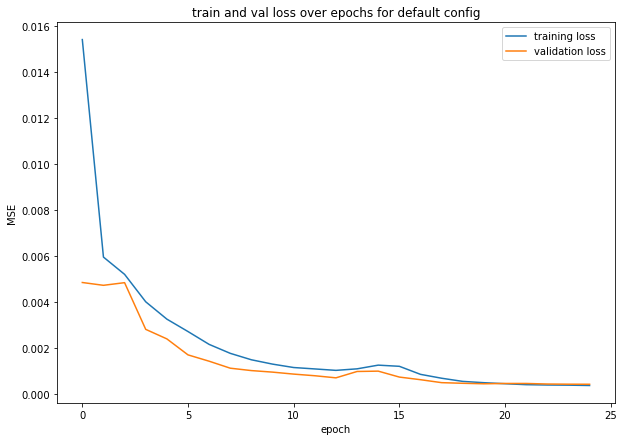

In [58]:
plt.figure(figsize = (10, 7))
plt.plot(range(len(train_loss_history)), train_loss_history, label = 'training loss')
plt.plot(range(len(val_loss_history)), val_loss_history, label = 'validation loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.title('train and val loss over epochs for default config')
plt.legend()


In [59]:
out = predict(val_loader,model)

In [60]:
out = out.reshape((out.shape[0], out.shape[-1]))

In [62]:
y_val.shape

(48, 2)

In [63]:
out.shape

(48, 2)

In [64]:
rankings = list(range(len(out)))

In [65]:
def error_of_index(i):
    predicted = out[i]
    ground_truth = y_val[i]
    return sum((predicted - ground_truth)**2)

In [68]:
rankings.sort(key=error_of_index)

### The best predictions

In [90]:
rankings[:5]

[43, 32, 8, 5, 13]

In [110]:
def show_image_and_points(ax, image_idx):
    ax.set_title(f"validation set number {image_idx}")
    ax.imshow(X_val[image_idx], cmap='Greys_r')
    pred_point = out[image_idx] * np.array([80, 60])
    gt_point = y_val[image_idx]* np.array([80, 60])
    ax.scatter(gt_point[0], gt_point[1], color='blue', label='ground truth')
    ax.scatter(pred_point[0], pred_point[1], marker='x', color='orange',label = 'prediction')
    ax.legend()

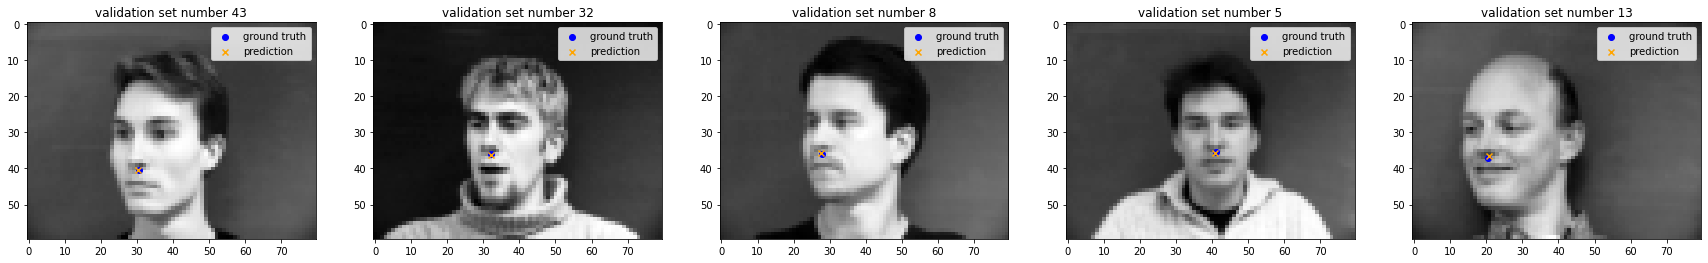

In [111]:
fig = plt.figure(figsize=(30, 6))
axes = fig.subplots(1, 5)
for ax, idx in list(zip(axes, rankings[:5])):
    show_image_and_points(ax, idx)

### The worst predictions

In [112]:
rankings[-5:]

[11, 12, 23, 16, 26]

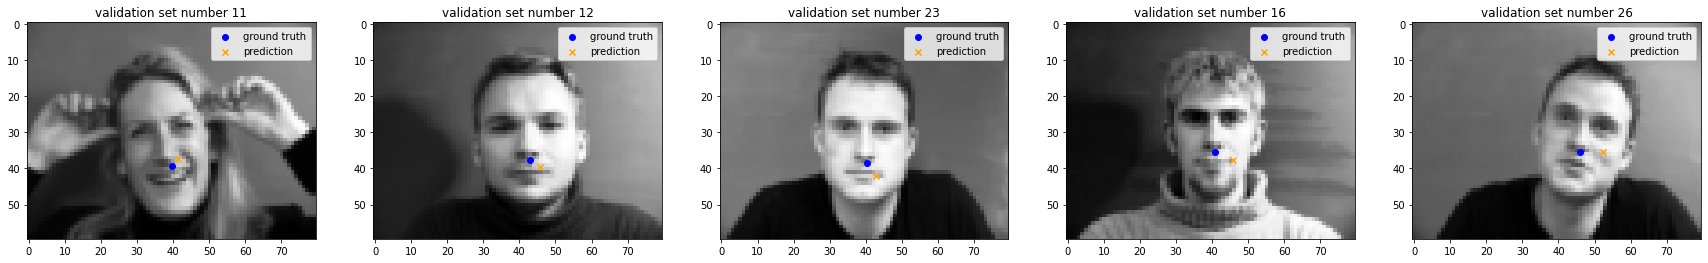

In [113]:
fig = plt.figure(figsize=(30, 6))
axes = fig.subplots(1, 5)
for ax, idx in list(zip(axes, rankings[-5:])):
    show_image_and_points(ax, idx)

### Visualizing filters

In [114]:
print(model)

NoseNet(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


In [127]:
model.conv1.weight.cpu().detach().numpy().shape

(12, 1, 5, 5)

In [129]:
retrieve = lambda x: x.weight.cpu().detach().numpy()

In [130]:
conv1_w, conv2_w, conv3_w = retrieve(model.conv1), retrieve(model.conv2), retrieve(model.conv3)

In [133]:
conv3_w.shape

(12, 12, 5, 5)

In [134]:
conv1_w.shape

(12, 1, 5, 5)

In [154]:
def show_filters(weights):
    rows, cols = weights.shape[0], weights.shape[1]
    titles = [[f"in: {in_c}, out: {out_c}" for in_c in range(cols)] for out_c in range(rows)]
    
    display_grid_of_images(weights, titles, w = 1.5, h = 1.5, normalize_rgb = False)

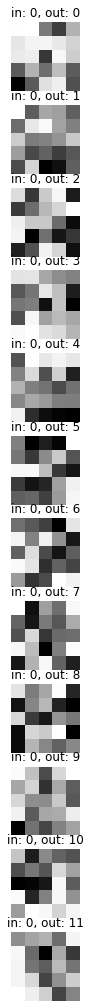

In [155]:
show_filters(conv1_w)

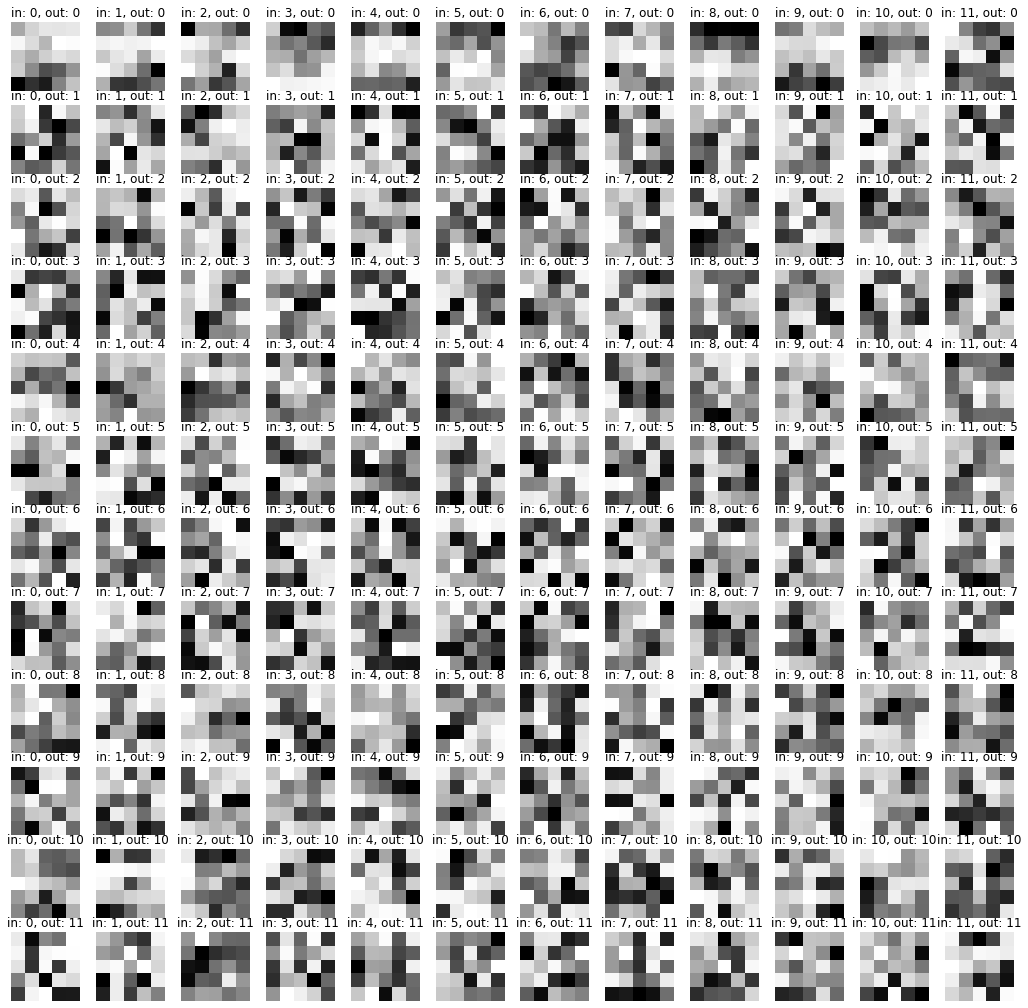

In [156]:
show_filters(conv2_w)

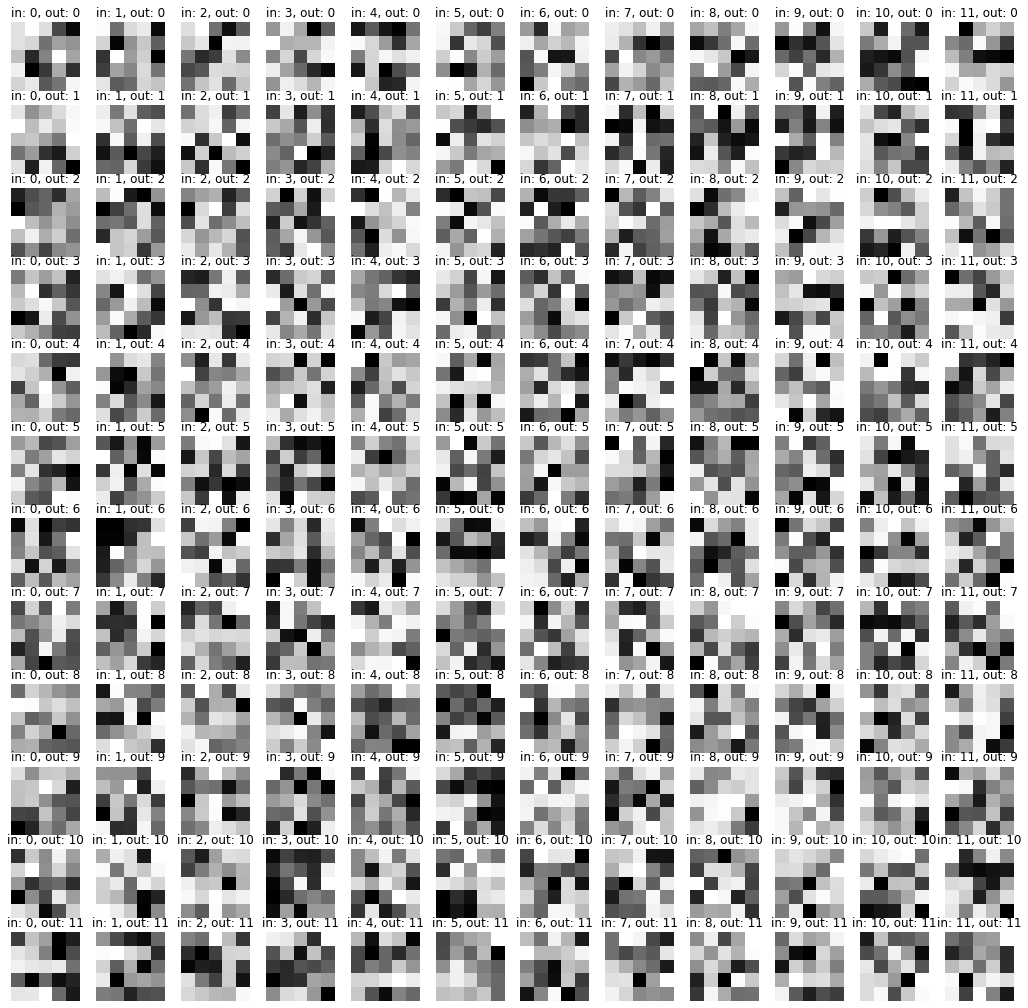

In [157]:
show_filters(conv3_w)